In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.backend import clear_session
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [2]:
# file loader
from os.path import isfile

def load_data(file):
    data = pd.read_csv(file, header=None)
    return data.values

In [3]:
window_size = 75   # 50Hz, 75 samples = 1.5s of movement
window_stride = 10
action_types = ('shield', 'reload', 'grenade', 'final', 'idle')
data_depth = 6

# Function to load dataset
def load_dataset(data_dir):
    dataset_x = []
    dataset_y = []

    # load data from all folders in data_dir
    for user_data_dir in os.listdir("Dataset"):
        print(f"Loading data from {user_data_dir}")
        for action_type in action_types:
            for i in range(1, 100, 1):
                # if file exists
                if not isfile(f"{data_dir}/{user_data_dir}/{action_type}{i}.csv"):
                    break
                data = load_data(f"{data_dir}/{user_data_dir}/{action_type}{i}.csv")
                dataset_x.append(np.int32(data))
                dataset_y.append(action_types.index(action_type))

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(len(action_types)):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    dataset_y = to_categorical(dataset_y, num_classes=len(action_types))
    return dataset_x, np.array(dataset_y)

# To do sliding window on the data
def sliding_window(data_X, data_Y, window_size, window_stride):
    dataset_X_w_sliding = []
    dataset_Y_w_sliding = []
    for i in range(len(data_X)):
        for j in range(0, len(data_X[i]) - window_size - 3 * window_stride+1, window_stride):
            dataset_X_w_sliding.append(data_X[i][j:j + window_size])
            dataset_Y_w_sliding.append(data_Y[i])
    return np.array(dataset_X_w_sliding), np.array(dataset_Y_w_sliding)


# load dataset
dataset_x, dataset_y = load_dataset("Dataset")

# load extra dataset
dataset_x_extra, dataset_y_extra = load_dataset("Dataset_extra")
dataset_x.extend(dataset_x_extra)
dataset_y = np.concatenate((dataset_y, dataset_y_extra), axis=0)

# # concatenate old dataset
# dataset_x_old, dataset_y_old = load_dataset("Dataset_old/user", dataset_users)
# dataset_x.extend(dataset_x_old)
# dataset_y = np.concatenate((dataset_y, dataset_y_old), axis=0)

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, stratify = dataset_y, random_state=66)

# backup test set for evaluation
test_x_eval = copy.deepcopy(test_x)
test_y_eval = copy.deepcopy(test_y)

# sliding window after train_test_split
train_x, train_y = sliding_window(train_x, train_y, window_size, window_stride)
test_x, test_y = sliding_window(test_x, test_y, window_size, window_stride)

# print dataset size after sliding window
print("Dataset size after sliding window: " + str(len(train_y)))

# calculate class weights
class_weights = {}
for i in range(len(action_types)):
    class_weights[i] = 1 / dataset_y[:, i].sum()

# print dataset disribution
train_y_temp = np.argmax(train_y, axis=1)
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(train_y_temp.tolist().count(i)) + " samples")

# backup test_x for c_sim and cosim
test_x_copy = copy.deepcopy(test_x)

# convert data from int16 to float32
train_x, test_x = np.float32(train_x)/4096, np.float32(test_x)/4096
# print("sample test x data: " + str(test_x[0]))

# summary of test dataset
test = np.argmax(test_y, axis=1)
print("\nTest set distribution")
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(test.tolist().count(i)) + " samples")


Loading data from data0
Loading data from data1
Loading data from data2
Loading data from data3
Loading data from data4
Dataset initialized with size: 733
Class 0 has 190 samples
Class 1 has 167 samples
Class 2 has 190 samples
Class 3 has 170 samples
Class 4 has 16 samples
Loading data from data0
Loading data from data1
Loading data from data2
Loading data from data3
Loading data from data4
Dataset initialized with size: 316
Class 0 has 74 samples
Class 1 has 75 samples
Class 2 has 74 samples
Class 3 has 74 samples
Class 4 has 19 samples
Dataset size after sliding window: 4619
Class 0 has 965 samples
Class 1 has 755 samples
Class 2 has 1276 samples
Class 3 has 1114 samples
Class 4 has 509 samples

Test set distribution
Class 0 has 253 samples
Class 1 has 182 samples
Class 2 has 313 samples
Class 3 has 289 samples
Class 4 has 168 samples


In [4]:
# sample data
# print("Sample data: " + str(train_x[0]))
print(train_x[1:2].shape)


(1, 75, 6)


In [5]:
# illustrate the data augmentation
import numpy as np
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation

def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def rotation(x, angle_range = np.pi):
    axis = np.random.uniform(low=-1, high=1, size=3)
    angle = np.random.uniform(low=-angle_range/2, high=angle_range/2)
    accel = np.matmul(x[:,:,:3] , axangle2mat(axis,angle))
    axis = np.random.uniform(low=-1, high=1, size=3)
    angle = np.random.uniform(low=-angle_range/2, high=angle_range/2)
    gyro = np.matmul(x[:,:,3:] , axangle2mat(axis,angle))
    return np.concatenate([accel, gyro], axis=-1)

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=2):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def augment(x):
    # x = jitter(x, sigma=0.01)
    x = np.concatenate([x[:, :, :3], np.array(scaling(x[:, :, 3:], sigma=0.1))], axis=-1)
    x = rotation(x, np.pi/12)
    # x = permutation(x)
    # x = np.concatenate([x[:, :, :3], np.array(magnitude_warp(x[:, :, 3:]))], axis=-1)
    x = window_warp(x, window_ratio=0.5, scales=[0.5, 2.])
    return x
    
def plot_augmented_data(data, label = ''):
    fig, axs = plt.subplots(4, 2, figsize=(20, 10))
    axs[0, 0].plot(data[0])
    axs[0, 0].set_title(f"Original {label}")
    axs[0, 1].plot(jitter(data)[0])
    axs[0, 1].set_title("Jitter")
    axs[1, 0].plot(scaling(data)[0])
    axs[1, 0].set_title("Scaling")
    axs[1, 1].plot(rotation(data, np.pi/3)[0])
    axs[1, 1].set_title("Rotation")
    axs[2, 0].plot(magnitude_warp(data)[0])
    axs[2, 0].set_title("Magnitude Warp")
    axs[2, 1].plot(time_warp(data)[0])
    axs[2, 1].set_title("Time Warp")
    axs[3, 0].plot(augment(data)[0])
    axs[3, 0].set_title("Augmented")

    plt.show()

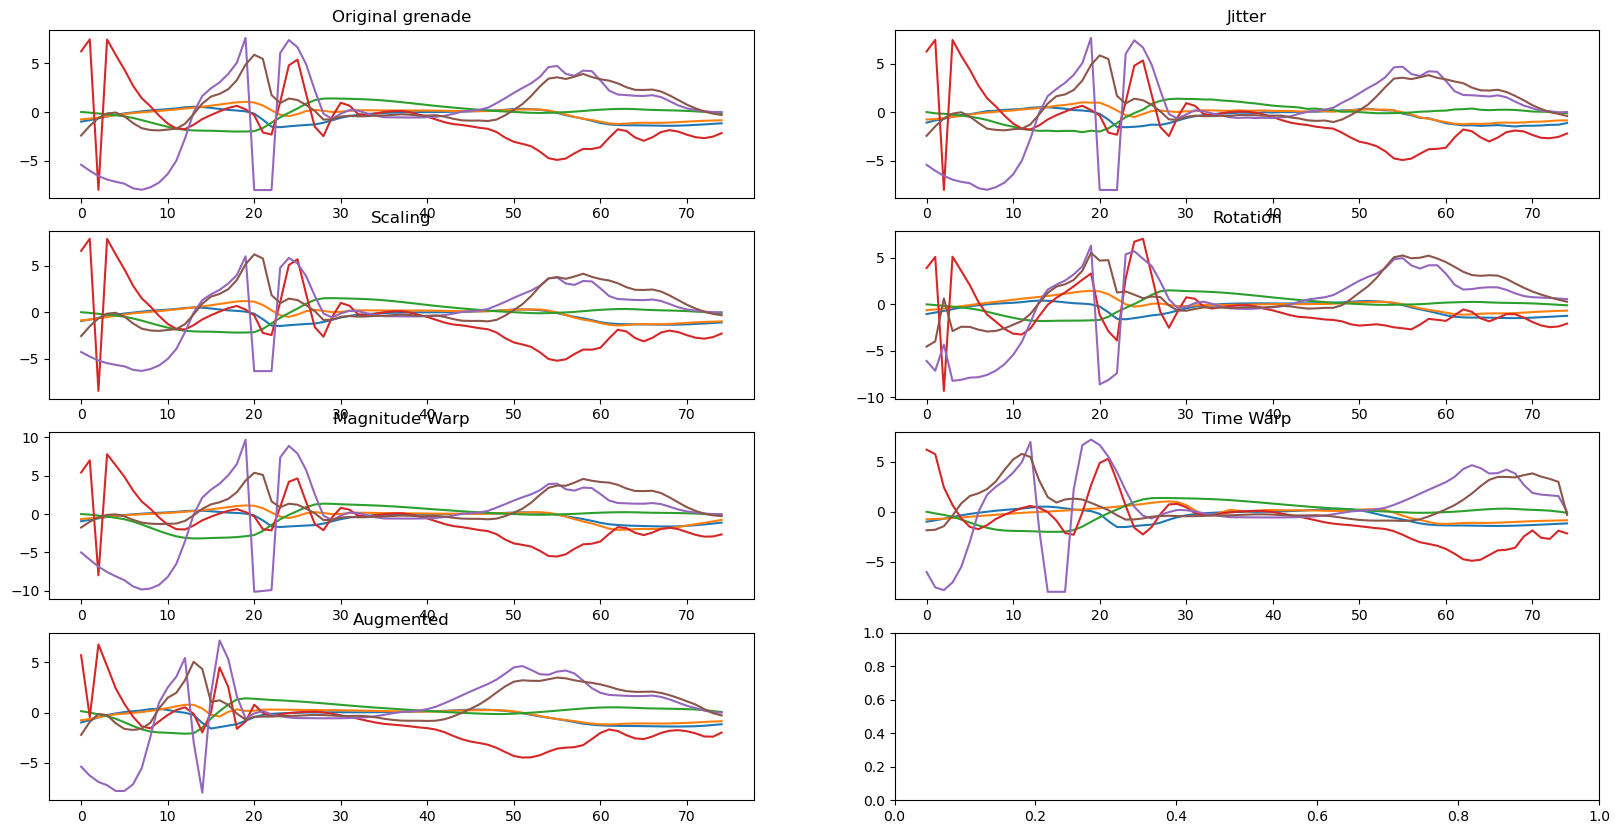

In [6]:
randint = np.random.randint(low=0, high=train_x.shape[0]-1, size=1)[0]
true_label = action_types[np.argmax(train_y[randint])]
plot_augmented_data(train_x[randint:randint+1], true_label)

In [7]:
# Data augmentation methods

from scipy.interpolate import CubicSpline      # for warping
from tensorflow import keras
from tensorflow.keras.utils import Sequence
# from augmentation import augment

class DataLoader(Sequence):
    def __init__(self, x_set, y_set, batch_size, aug=True):
        super().__init__()
        self.x, self.y = x_set, y_set
        self.aug_x = x_set
        self.batch_size = batch_size
        self.aug = aug
    
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.aug_x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.aug:
            self.aug_x = augment(self.x)
        


In [8]:
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Softmax, GlobalAveragePooling1D, GlobalMaxPooling1D, InputLayer
from tensorflow.keras.optimizers import Adam

conv1kernel = 15
conv1filters = 64

clear_session()
model = Sequential()

model.add(InputLayer(input_shape=(window_size, data_depth)))
model.add(Conv1D(conv1filters, conv1kernel, strides=1, activation='relu'))
# model.add(MaxPooling1D(5, strides=5))
# model.add(Conv1D(64, 13, activation='relu'))
# model.add(Dropout(0.5)) # 50% dropout

# conv2filters = 32
# conv2kernel = 3
# conv2stride = 1
# model.add(Conv1D(conv2filters, conv2kernel, strides=conv2stride, activation='relu'))
# model.add(Dropout(0.5)) # 50% dropout

model.add(GlobalMaxPooling1D())
# model.add(Flatten())

# model.add(Dense(16, activation='relu'))
model.add(Dense(len(action_types)))
model.add(Softmax())

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# performance before training
# y_prediction = np.argmax(model.predict(test_x), axis=1)
# result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
# sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 61, 64)            5824      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 6,149
Trainable params: 6,149
Non-trainable params: 0
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import datetime

# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0, verbose=1)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S-w-extra-dataset")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [40]:
import time

# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 5000
    batch_size = 32
    # train_augmented = DataLoader(train_x, train_y, batch_size, aug=False)
    train_augmented = DataLoader(train_x, train_y, batch_size, aug=True)
    history = model.fit(train_augmented, \
        epochs=epochs, \
        batch_size=batch_size,\
        validation_data=(test_x, test_y), \
        class_weight = class_weights, \
        callbacks = [model_checkpoint_callback, \
            reduce_lr, \
            early_stopping, \
            tensorboard_callback,\
        ], \
        verbose=verbose)
    # _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)

    return model, history

start_time = time.time()
model, history = train_network(model, train_x, train_y, test_x, test_y)
print("Training time: %s seconds" % (time.time() - start_time))

Epoch 1/5000
145/145 [==============================] - 2s 13ms/step - loss: 0.0045 - accuracy: 0.7499 - val_loss: 0.4296 - val_accuracy: 0.8573
Epoch 2/5000
145/145 [==============================] - 1s 7ms/step - loss: 0.0018 - accuracy: 0.9041 - val_loss: 0.1969 - val_accuracy: 0.9452
Epoch 3/5000
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 0.9361 - val_loss: 0.1470 - val_accuracy: 0.9610
Epoch 4/5000
145/145 [==============================] - 1s 5ms/step - loss: 9.8719e-04 - accuracy: 0.9513 - val_loss: 0.1185 - val_accuracy: 0.9676
Epoch 5/5000
145/145 [==============================] - 1s 6ms/step - loss: 8.7456e-04 - accuracy: 0.9552 - val_loss: 0.1068 - val_accuracy: 0.9710
Epoch 6/5000
145/145 [==============================] - 1s 6ms/step - loss: 8.9102e-04 - accuracy: 0.9506 - val_loss: 0.0926 - val_accuracy: 0.9751
Epoch 7/5000
145/145 [==============================] - 1s 7ms/step - loss: 6.7964e-04 - accuracy: 0.9660 - val_loss: 0.083

# Draw confusion matrix

Proportion of filtered prediction: 1.0
Highest false confidence: 0.9945233


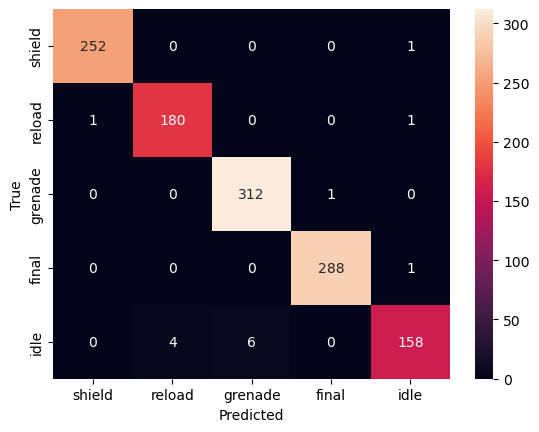

Accuracy: 0.9875518672199171


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

highest_false_confidence = 0

model.load_weights(checkpoint_filepath)
y_prediction = model.predict(test_x)

threshold = 0
# threshold = 0.9
# remove all the prediction with probability less than threshold
filtered_pred = []
filtered_test = []
for i in range(len(y_prediction)):
    if np.max(y_prediction[i]) > threshold:
        filtered_pred.append(np.argmax(y_prediction[i]))
        filtered_test.append(np.argmax(test_y[i]))
    if np.max(y_prediction[i]) > highest_false_confidence and np.argmax(y_prediction[i]) != np.argmax(test_y[i]):
        highest_false_confidence = np.max(y_prediction[i])

# print proportion of filtered prediction
print("Proportion of filtered prediction: " + str(len(filtered_pred)/len(y_prediction)))

# print highest false confidence
print("Highest false confidence: " + str(highest_false_confidence))

result = confusion_matrix(filtered_test, filtered_pred)

# result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print accuracy
print("Accuracy: " + str(np.sum(np.diag(result))/np.sum(result)))


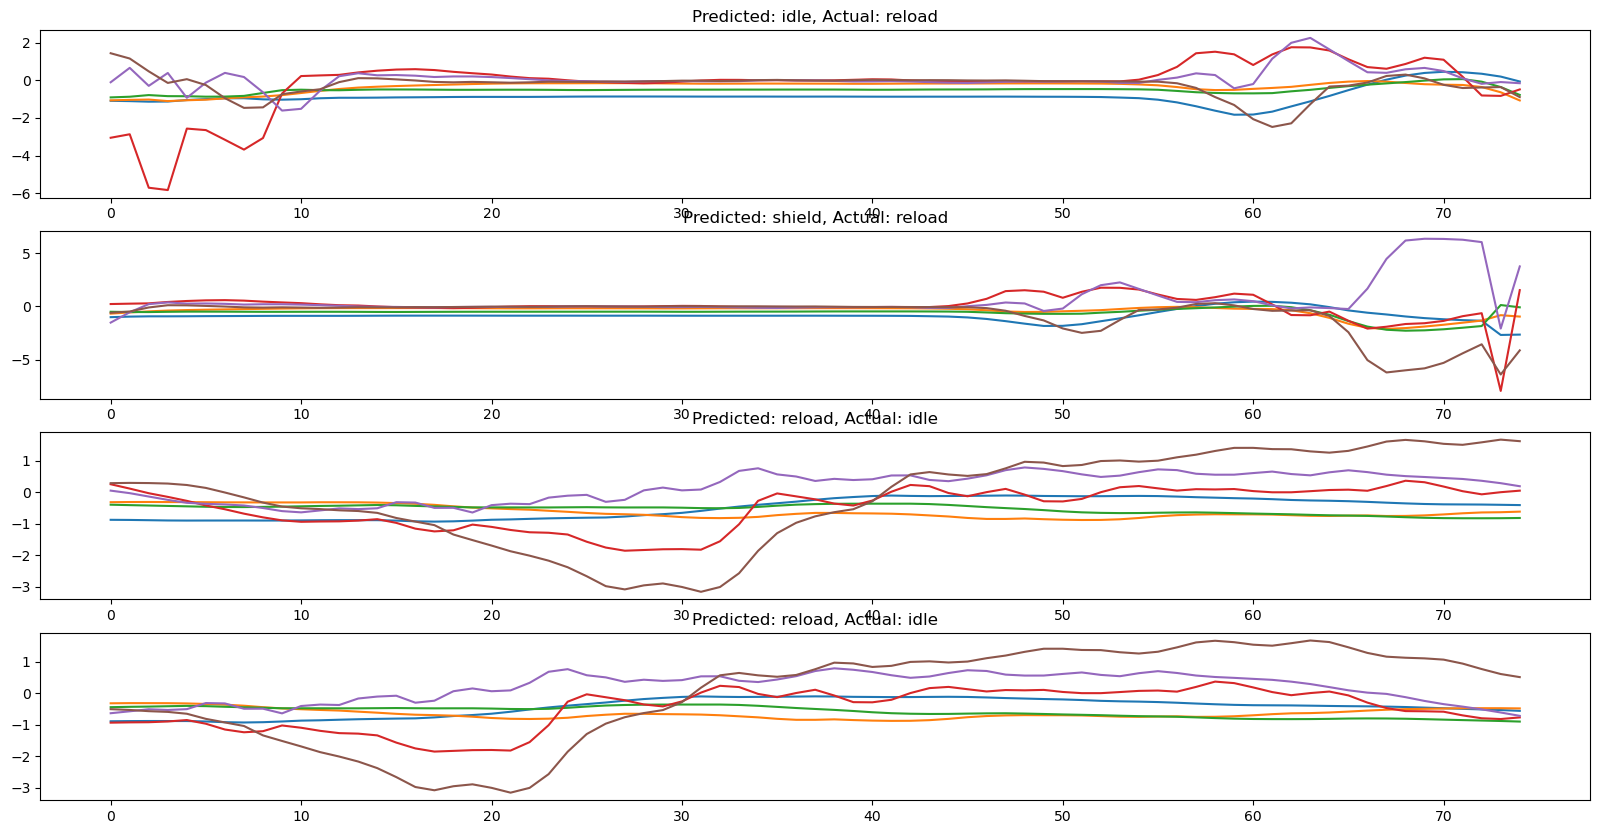

In [11]:
import matplotlib.pyplot as plt

model.load_weights(checkpoint_filepath)
# y_prediction = model.predict(train_x)
y_prediction = model.predict(test_x)
filtered_pred = []
filtered_test = []

fig, axs = plt.subplots(4, figsize=(20, 10))
index = 0
for i in range(len(y_prediction)):
    if np.argmax(y_prediction[i]) != np.argmax(test_y[i]) and max(y_prediction[i]) > threshold:
        # axs[index].plot(train_x[i])
        # axs[index].set_title("Predicted: " + action_types[np.argmax(y_prediction[i])] + ", Actual: " + action_types[np.argmax(train_y[i])])
        axs[index].plot(test_x[i])
        axs[index].set_title("Predicted: " + action_types[np.argmax(y_prediction[i])] + ", Actual: " + action_types[np.argmax(test_y[i])])
        index += 1
        if index == 4:
            break


In [12]:
print(f"window shape: {window_size, data_depth}")
print(f"kernel shape: {conv1kernel, data_depth}")
print(f"first layer weights shape: {model.layers[0].get_weights()[0].shape}")
print(f"first layer output shape: {model.layers[0].output_shape}")
print(f"second layer weights shape: {model.layers[2].get_weights()[0].shape}")
print(f"second layer output shape: {model.layers[2].output_shape}")

window shape: (75, 6)
kernel shape: (15, 6)
first layer weights shape: (15, 6, 64)
first layer output shape: (None, 61, 64)
second layer weights shape: (64, 5)
second layer output shape: (None, 5)


In [13]:
# print out weights and biases one by one
layers_indexes = [0, 2]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    print(weights[0].shape)
    # print(f"INPUT_DTYPE model_param_{layer_name}_weights")
    # for i in range(weights[0].shape[-1]):
    #     print("index", i)
    #     print(np.transpose(np.transpose(weights[0])[i]))
    # print(f"INPUT_DTYPE model_param_{layer_name}_biases")
    print(weights[1].shape)

(15, 6, 64)
(64,)
(64, 5)
(5,)


In [17]:
import array
def dump_numbers(filename, numbers):
    with open(filename, 'wb') as fp:
        array.array('f', numbers).tofile(fp)

In [21]:
# directly print out weights and biases
layers_indexes = [0, 2]

# for layer_index in layers_indexes:
#     print(model.layers[layer_index].name)

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]

    if layer_index == 0:
        layer_name = "CNN"
        # weights last dimension to first dimension
        weights = np.transpose(weights, (2, 0, 1))
        weights_size_definition = "[CNN_KERNEL_COUNT][CNN_KERNEL_LENGTH][CNN_KERNEL_DEPTH]"
        bias_size_definition = "[CNN_KERNEL_COUNT]"
    else:
        layer_name = "dense"
        weights = np.transpose(weights, (1, 0))
        weights_size_definition = "[DENSE_OUTPUT_NODES][DENSE_INPUT_NODES]"
        bias_size_definition = "[DENSE_OUTPUT_NODES]"
    # print(f"static CNN_DTYPE {layer_name}_weights{weights_size_definition} = {{" + ", ".join([str(x) for x in weights.reshape(-1)]) + "};")
    # print(f"static CNN_DTYPE {layer_name}_bias{bias_size_definition} = {{" + ", ".join([str(x) for x in biases]) + "};")
    print(f"static CNN_DTYPE {layer_name}_weights{weights_size_definition} = {{" + ", ".join([str(x) for x in weights.reshape(-1)]) + "};")
    print(f"static CNN_DTYPE {layer_name}_bias{bias_size_definition} = {{" + ", ".join([str(x) for x in biases]) + "};")

    # save weights and biases to file
    np.save(f"{layer_name}_weights.npy", weights)
    np.save(f"{layer_name}_bias.npy", biases)


static CNN_DTYPE CNN_weights[CNN_KERNEL_COUNT][CNN_KERNEL_LENGTH][CNN_KERNEL_DEPTH] = {0.1339567, 0.50224197, 0.27239823, -0.1782905, 0.10952891, -0.027663555, 0.09997873, 0.41366485, 0.22217144, -0.12143662, 0.10851182, -0.03186083, 0.08396414, 0.45298198, 0.24958405, -0.062197678, 0.072139494, -0.05502924, 0.039091922, 0.48770827, 0.33650127, -0.03868702, 0.13873804, -0.064121775, -0.025664177, 0.48399258, 0.23858562, -0.06625191, 0.03132558, -0.044140726, -0.0572779, 0.38818654, 0.33766392, -0.120995656, 0.055213038, 0.03388962, -0.094574094, 0.3406077, 0.25340906, -0.06348313, -0.0332805, 0.113547, 0.032154717, 0.19207957, 0.23670271, -0.058001064, -0.07276564, 0.0638474, 0.016068757, 0.120365836, 0.22183432, 0.019637566, -0.009694519, 0.11664492, -0.07680742, 0.021374112, 0.2353925, 0.019732628, -0.046376783, 0.08104334, -0.09631936, 0.03042913, 0.26498774, -0.06636251, -0.14437939, 0.00052885304, -0.052256256, 0.017864835, 0.299632, -0.055209976, -0.1295536, -0.020326236, -0.0471

In [25]:
# directly print out test dataset
n_values_per_line = 10
dataset_size = len(test_x)
# dataset_size = 4
dataset_start_index = 0
print("#define DATASET_SIZE", dataset_size)

# print out float test dataset
print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(x) for x in test_x[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

# # save the test dataset
np.save("test_x.npy", test_x_copy)
np.save("test_y.npy", test_y)

#define DATASET_SIZE 4
const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {
-1.1411133, -0.8041992, 0.4267578, 2.199707, -1.3586426, -1.7749023,
-1.2866211, -0.8652344, 0.6062012, 0.8996582, -2.7316895, -2.9677734,
-1.4221191, -0.9250488, 0.77197266, -0.6333008, -4.3945312, -3.4387207,
-1.4746094, -1.0866699, 0.8984375, -0.38623047, -5.3518066, -3.2216797,
-1.4829102, -1.2861328, 1.0007324, 1.4047852, -5.23584, -3.2180176,
-1.4851074, -1.4099121, 1.092041, 2.7451172, -5.190918, -3.4204102,
-1.4904785, -1.4709473, 1.1816406, 2.4848633, -5.3862305, -3.8430176,
-1.5109863, -1.5527344, 1.2421875, 2.0922852, -5.688965, -4.401367,
-1.5739746, -1.6894531, 1.2463379, 2.8356934, -6.242676, -4.9108887,
-1.6564941, -1.7839355, 1.1623535, 4.3881836, -6.979492, -5.2993164,
-1.748291, -1.7797852, 0.99194336, 5.427246, -7.5219727, -5.395996,
-1.8308105, -1.7011719, 0.7651367, 5.4140625, -7.9501953, -5.3774414,
-1.8820801, -1.5800781, 0.4951172, 4.755615, 7.9958496, -5.83667,
-1.8591309, -1

In [59]:
# directly print out integer test dataset
n_values_per_line = 10
dataset_size = len(test_x)
# dataset_size = 10
dataset_start_index = 0
print("#define DATASET_SIZE", dataset_size)

# print out float test dataset
print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(x) for x in test_x_copy[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

# save the test dataset
np.save("test_x.npy", test_x_copy)
np.save("test_y.npy", test_y)

#define DATASET_SIZE 1041
const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {
-5594, -4626, 145, -74, 640, -14227,
-6126, -5332, 107, 2497, -1875, -16849,
-6591, -5983, -93, 4598, -2173, -19164,
-6982, -6583, -431, 5795, -1332, -21880,
-7512, -7109, -911, 7948, -1483, -23853,
-7713, -7665, -1519, 12825, -2550, -23801,
-8052, -8142, -2146, 18087, -2701, -24676,
-8429, -8281, -2871, 23562, -6869, -24839,
-8599, -8082, -3573, 27518, -10982, -25154,
-8736, -7554, -4268, 30705, -15810, -24853,
-8680, -6869, -4928, 32481, -19542, -22881,
-8450, -6189, -5480, -32445, -21218, -21263,
-8093, -5364, -5894, -32445, -22289, -20744,
-7613, -4340, -6174, 31524, -23309, -19695,
-7029, -3163, -6349, 27363, -24199, -18023,
-6340, -1974, -6430, 20649, -24954, -16968,
-5480, -975, -6487, 13208, -24540, -16767,
-4464, -309, -6517, 8825, -21853, -16102,
-3383, 232, -6497, 8030, -17214, -14546,
-2377, 822, -6351, 9195, -12835, -11493,
-1506, 1549, -6109, 9799, -10926, -8569,
-683, 2405, -5858, 8

In [21]:
test_x[0].reshape((1, 75, 6)).shape

(1, 75, 6)

In [22]:
# print model output without the last layer
from keras.models import Model
model_cnn_output = Model(inputs=model.input, outputs=model.layers[0].output)
model_cnn_averaged_output = Model(inputs=model.input, outputs=model.layers[2].output)
model_raw_output = Model(inputs=model.input, outputs=model.layers[3].output)
cnn_result = model_cnn_output.predict(test_x[1].reshape((1, 75, 6)))
cnn_average = model_cnn_averaged_output.predict(test_x[1].reshape((1, 75, 6)))
raw_result = model_raw_output.predict(test_x[1].reshape((1, 75, 6)))

# print("CNN result:")
# for i in range(0, cnn_result.shape[1]):
#     print(cnn_result[0][i])

print("CNN average:")
# print in a single line
print(", ".join([str(x) for x in cnn_average[0]]))
print("Raw result:")
print(", ".join([str(x) for x in raw_result[0]]))

CNN average:
19.294968, -5.823475, -3.8433428, -19.920277, -9.031974
Raw result:
1.0, 1.23367e-11, 8.936345e-11, 9.311846e-18, 4.986148e-13


In [27]:
# print model output without the last layer
from keras.models import Model
model_cnn_output = Model(inputs=model.input, outputs=model.layers[0].output)
model_cnn_averaged_output = Model(inputs=model.input, outputs=model.layers[1].output)
model_raw_output = Model(inputs=model.input, outputs=model.layers[2].output)
cnn_result = model_cnn_output.predict(test_x)
cnn_average = model_cnn_averaged_output.predict(test_x)
raw_result = model_raw_output.predict(test_x)

# print("CNN result:")
# for i in range(0, cnn_result.shape[1]):
#     print(cnn_result[0][i])

print("CNN average:")
for i in range(0, cnn_average.shape[0]):
    print(",\t".join([str(x) for x in cnn_average[i]]))
print("Raw result:")
for i in range(0, raw_result.shape[0]):
    print(", ".join([str(x) for x in raw_result[i]]))

CNN average:
6.7097015,	2.9218407,	4.841809,	6.041976,	5.515575,	3.2953606,	7.050071,	4.7936735,	6.5069065,	9.234384,	4.9190326,	4.526947,	6.1249404,	3.9802976,	2.7817225,	3.732797,	5.5217514,	7.114239,	15.746942,	6.961804,	4.9824595,	4.1712546,	5.895539,	7.7618012,	9.671258,	4.019223,	4.4270835,	7.5450106,	4.622211,	1.1223615,	7.552165,	7.3417883,	7.2477117,	5.721238,	6.141092,	1.3968518,	5.1296206,	4.6954913,	4.9278307,	3.2237902,	6.1570706,	3.5494661,	3.8665085,	11.398041,	5.222365,	5.8920727,	2.27568,	1.8740823,	5.219378,	5.231351,	7.463782,	3.1580322,	6.6195674,	2.432109,	4.934912,	2.4859622,	5.1940575,	3.474264,	9.212678,	3.7292721,	2.3566043,	9.547143,	5.9344587,	9.461745
6.7097015,	2.9218407,	4.841809,	6.041976,	4.2018967,	3.2953606,	7.050071,	4.7936735,	6.5069065,	5.01877,	4.9190326,	4.526947,	6.1249404,	3.9802976,	2.7817225,	3.732797,	5.5217514,	7.114239,	9.131677,	5.9872293,	4.9824595,	4.1712546,	5.895539,	7.7618012,	6.825564,	4.019223,	4.4270835,	7.5450106,	4.622211,	1.1223